## Imports

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

## Load Data

In [2]:
# Load the training and test datasets
train = pd.read_csv('/kaggle/input/higgs-boson-detection-2025/train.csv')
test = pd.read_csv('/kaggle/input/higgs-boson-detection-2025/test.csv')

## Preprocess Data

In [3]:
# Separate the features and the labels
X = train.drop(columns='label')  # Drop the label column
y = train['label']  # The label column

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## Train Model

### Logistic Regression Model to Establish Baseline

In [4]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score

# # Train a Logistic Regression model
# baseline_model = LogisticRegression()
# baseline_model.fit(X_train, y_train)

# # Make predictions on the validation set
# y_pred_val = baseline_model.predict_proba(X_val)[:, 1]

# # Calculate AUROC score
# auc_score = roc_auc_score(y_val, y_pred_val)
# print(f'Logistic Regression AUROC: {auc_score}')

In [5]:
# Initialize the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc')
# model.get_params()

### Hyperparameter Tuning

In [6]:
# # Set the parameters for the model
# params = {
#     'max_depth': [5, 8], # Maximum depth of trees
#     'learning_rate': [0.02, 0.05, 0.07], # Step size at each iteration
#     'n_estimators': [300, 500], # Number of boosting rounds
#     'subsample': [0.5, 0.9],  # Fraction of samples used per tree
#     'colsample_bytree': [0.5, 0.8],  # Fraction of features used per tree
# }

# grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc')
# grid_search.fit(X_train, y_train)

# # Best hyperparameters
# best_params = grid_search.best_params_
# print("Best Parameters: ", best_params)
# print("Best AUROC: ", grid_search.best_score_)

Best Parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.9}
Best AUROC:  0.800134822432144


In [12]:
best_params = {
    'max_depth': 8, # Maximum depth of trees
    'learning_rate': 0.02, # Step size at each iteration
    'n_estimators': 500, # Number of boosting rounds
    'subsample': 0.9,  # Fraction of samples used per tree
    'colsample_bytree': 0.8,  # Fraction of features used per tree
}

# Train the model using the best hyperparameters
best_model = xgb.XGBClassifier(**best_params, objective='binary:logistic', eval_metric='auc')
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Evaluate Model

XGBoost AUROC:  0.804296105216316


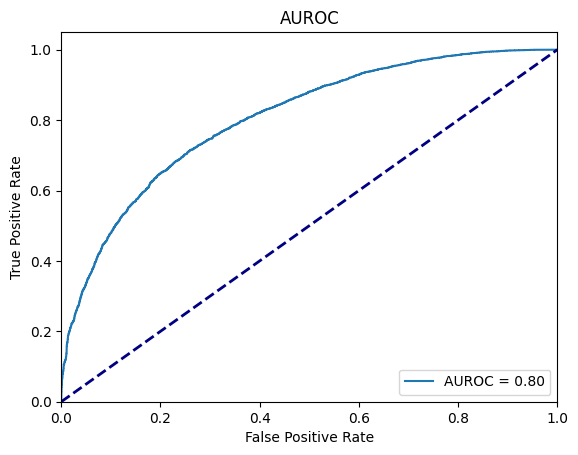

In [13]:
# Predictions on the validation set
y_val_pred = best_model.predict_proba(X_val)[:, 1] # Get probabilities for class 1

# Evaluate performance using AUROC
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
auroc = auc(fpr, tpr)
print("XGBoost AUROC: ", auroc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='AUROC = %0.2f' % auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC')
plt.legend(loc="lower right")
plt.show()

## Test Set Predictions

In [9]:
# Get predictions on the test set
y_test_pred = best_model.predict_proba(test)[:, 1]

# Prepare the submission in the required format
submission = pd.read_csv('/kaggle/input/higgs-boson-detection-2025/sample_submission.csv')
submission['Id'] = submission['Id'].apply(lambda x: f"{float(x):.18e}")
submission['Predicted'] = y_test_pred

# Save the predictions to a CSV file
submission.to_csv('submission.csv', index=False)

submission.head()

,Id,Predicted
0,0.000000000000000000e+00,0.091480
1,1.000000000000000000e+00,0.285538
2,2.000000000000000000e+00,0.747177
3,3.000000000000000000e+00,0.856162
4,4.000000000000000000e+00,0.496133
